In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import copy
import cmaps
import dyl_function_slope as dyl
import areamean_dhq as dhq
from matplotlib.colors import BoundaryNorm
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from cartopy.util import add_cyclic_point
from scipy import stats
from scipy.stats import pearsonr

ccmap_cat = cmaps.NEO_div_vegetation_a
ccmap_u = cmaps.cmp_b2r
plt.rcParams['font.family'] = 'Helvetica'

In [15]:
def plot_meri_section(ax1, lat,level,level_label,
                      meri_data,meri_data_levels,ccmap,consistency,
                      left_title,right_title,colorbar_label,color_bar_ticks,sequence,
                      meri_clim=None,meri_clim_levels=None):

    cycle_data, cycle_lat = add_cyclic_point(meri_data, coord=lat)
    lat = np.asarray(lat)
    level = np.asarray(level)
    cycle_lat, cycle_level = np.meshgrid(cycle_lat, np.arange(level.shape[0]))
    #cycle_MON = cycle_MON.filled(np.nan)
    cycle_data = cycle_data.filled(np.nan)

    c1 = ax1.contourf(cycle_lat, cycle_level, cycle_data, cmap=ccmap, levels=meri_data_levels, extend='both')
    if meri_clim is not None:
        cycle_clim, cycle_mon = add_cyclic_point(meri_clim, coord=lat)
        c2 = ax1.contour(cycle_lat, cycle_level, cycle_clim, levels=meri_clim_levels, colors='k', alpha=0.6,
                             linewidths=.5)
        ax1.clabel(c2, inline=True, fontsize=6)

    #if consistency is not None:
    cycle_dot, cycle_mon = add_cyclic_point(consistency, coord=lat)
    significance = np.ma.masked_where(cycle_dot == False, cycle_dot)
    c3 = ax1.contourf(cycle_lat, cycle_level, significance, colors='none', hatches=['////'])

    if hasattr(c3, 'collections'):
        collections = c3.collections
    else:
        collections = [c3]
    # 设置 hatch 样式
    for collection in collections:
        collection.set_edgecolor('grey')
        collection.set_linewidth(0)

    ax1.set_xticks([10, 20, 30, 40,50,60])  # 指定要显示的经纬度
    ax1.xaxis.set_major_formatter(LatitudeFormatter())  # 刻度格式转换为经纬度样式
    ax1.yaxis.set_ticks(np.arange(level.shape[0]), level_label)  # 指定要显示的经纬度
    ax1.tick_params(axis='y',  direction='in',labelsize=7)  # 设置x轴刻度数字大小
    ax1.tick_params(axis='x', labelsize=7)  # 设置y轴刻度数字大小
    ax1.text(-0.15, 1.15, sequence, transform=ax1.transAxes, fontsize=10, fontweight='bold', va='top', ha='left')
    ax1.set_title(left_title, loc='left', fontsize=7)
    ax1.set_title(right_title, loc='right', fontsize=7)
    if sequence == 'A':
        ax1.set_ylabel('Level (hPa)', fontsize=7)

    cb = fig.colorbar(c1, orientation='vertical', shrink=0.8, fraction=0.15, pad=0.05, extend='both')
    #cb.ax.yaxis.set_major_locator(MultipleLocator(0.2))
    # cb.ax.set_size([0.5,0.2])
    cb.set_ticks(color_bar_ticks)
    cb.ax.tick_params(axis='y', which='major', direction='in', length=3, labelsize=6)
    # cb.ax.tick_params(which='minor', direction='in', length=5)
    cb.set_label(label=colorbar_label, fontsize=7)
    #cb.ax.tick_params(labelsize=6)

    return c1

In [3]:
def nan_models_times_levels_am_4D(ds):
    time_label,level_label, lat_label, lon_label = ds.dims
    nrows = len(ds[lat_label])
    ncols = len(ds[lon_label])
    ntimes = len(ds[time_label])
    nlevels = len(ds[level_label])
    latsr = np.deg2rad(ds[lat_label].values).reshape((nrows, 1))
    weight_matrix = np.repeat(np.cos(latsr), ncols, axis=1)
    ds_gl = np.zeros((ntimes,nlevels))
    ds_w = ds * weight_matrix
    for i in range(nlevels):
        weight_sum = copy.deepcopy(weight_matrix)
        if ds_w[:,i].isnull().any():
            weight_sum[ds_w[:,i].isnull().data] = np.nan
            ds_gl[:,i] = ds_w[:,i].sum(dim=[lon_label, lat_label]) / np.nansum(weight_sum)
    ds_mean = xr.DataArray(ds_gl, dims=(time_label,level_label),
                           coords={time_label: ds[time_label],level_label: ds[level_label]})
    return ds_mean

In [12]:
models = ["BCC-CSM2-MR", "CanESM5", "CESM2-WACCM", "FGOALS-g3", "IITM-ESM",
          "KACE-1-0-G", 'INM-CM5-0', "IPSL-CM6A-LR", "MIROC6", "MPI-ESM1-2-HR",
          "MRI-ESM2-0", "NorESM2-LM", "NorESM2-MM", "TaiESM1"]
IN_DIR = "/home/dongyl/Work2024/Tl/saved_npy/model_turbulence_data/h+ssp585_1980-2020/95p_frequency"
LAT_MIN, LAT_MAX = 20, 60
Q = 0.95
#############1 计算TI1 VWS DEF垂向剖面##########################################
TI_all_models_20_40_150hpa_list=[]
TI_all_models_20_40_250hpa_list=[]
TI_all_models_list = []
TI_all_models_trend_list = []
TI_all_models_p_values_list = []
TI_all_models_aream_trend_list = []
TI_all_models_aream_list=[]
selected_plevs = ['500', '300', '250', '200', '150', '100', '50']
for model in models:
    print(f"Processing {model}")
    file1 = f"{IN_DIR}/TI1_h+ssp585_{model}_1980-2020_exceed_pct_{int(Q * 100)}p.nc"
    TI_array = xr.open_dataset(file1)["frequency"].sel(lat=slice(10,60))#(time,plev,lat,lon)
    TI_20_40_array = xr.open_dataset(file1)["frequency"].sel(lat=slice(10,60))
    print(TI_array.dims)

    TI_array = TI_array[:, :-1].mean(dim='lon', skipna=True)#(time,plev,lat)
    print(TI_array.plev)#array([50000., 30000., 25000., 20000., 15000., 10000.,  5000.], dtype=float32)

    TI_all_models_list.append(TI_array)
    TI_trend, TI_p_values = dyl.get_slope_p_3D(TI_array)
    TI_all_models_trend_list.append(TI_trend)
    TI_all_models_p_values_list.append(TI_p_values)

    #计算区域平均的TI,VWS,DEF
    TI_array = xr.open_dataset(file1)["frequency"].sel(lat=slice(10,60))
    TI_levels = TI_array.mean(dim='lon', skipna=True)
    TI_all_models_aream_list.append(dhq.mask_am4D(xr.open_dataset(file1)["frequency"].sel(lat=slice(20, 40))))
    TI_levels_trend,TI_levels_p_level = dyl.get_slope_p_3D(TI_levels)
    TI_levels_aream_trend,TI_levels_aream_p_level = dyl.calculate_trend_2D(dhq.mask_am4D(xr.open_dataset(file1)["frequency"].sel(lat=slice(20, 40))))
    TI_all_models_aream_trend_list.append(TI_levels_aream_trend)

TI_all_models_trend_stack = np.stack(TI_all_models_trend_list, axis=0)
TI_all_models_p_values_stack = np.stack(TI_all_models_p_values_list, axis=0)
# 150hPa和250hPa,20-40N的数组，(models,time)
TI_all_models_aeram_trend_stack = np.stack(TI_all_models_aream_trend_list,axis=0)
TI_all_models_aream_stack = np.stack(TI_all_models_aream_list,axis=0)
TI_all_models_aream_clim_stack = np.nanmean(TI_all_models_aream_stack,axis=1)
#计算几何平均的趋势和显著性
TI_freq_ay_zonmean = np.stack(TI_all_models_list,axis=0)
TI_freq_trend, TI_freq_p_values = dyl.calculate_trend_3D_ndarray(np.nanmean(TI_freq_ay_zonmean,axis=0))
print(TI_freq_trend.shape)
TI_mask_trend = TI_freq_p_values < 0.05
TI_significant_points= np.where(TI_mask_trend, True, False)
#得到几何平均的气候态
print(TI_freq_ay_zonmean.shape)
TI_freq_clim = np.nanmean(np.nanmean(TI_freq_ay_zonmean,axis=0),axis=0)


# 原始 lon 是 [0, 0.25, ..., 359.75]
old_lon = xr.open_dataset(file1)["frequency"].lon.values  # 获取原始值
# 转换为 [-180, 180)
new_lon = np.where(old_lon > 180, old_lon - 360, old_lon)
# 获取排序索引（使 new_lon 升序）
sort_idx = np.argsort(new_lon)
# 按新顺序重新排列数据和坐标
#sorted_u_1980_2010_ay = u_1980_2010_ay.isel(lon=sort_idx).values
#sorted_u_2060_2090_ay = u_2060_2090_ay.isel(lon=sort_idx).values
sorted_lon = new_lon[sort_idx]
'''TI_ext_trend_all_models_list150_ay = np.stack(TI_ext_trend_all_models_list150,axis=0)
TI_ext_trend_all_models_list250_ay = np.stack(TI_ext_trend_all_models_list250,axis=0)
TI_ext_trend_all_models_list150 = xr.DataArray(
    TI_ext_trend_all_models_list150_ay,
    dims=["model", "lat","lon"],
    coords={
        "model": np.arange(len(models)),
        "lat":TI_array.lat,
        "lon": sorted_lon,  # 排序后的 lon
    }
)
TI_ext_trend_all_models_list250 = xr.DataArray(
    TI_ext_trend_all_models_list250_ay,
    dims=["model", "lat","lon"],
    coords={
        "model": np.arange(len(models)),
        "lat":TI_array.lat,
        "lon": sorted_lon,  # 排序后的 lon
    }
)'''

Processing BCC-CSM2-MR
('year', 'plev', 'lat', 'lon')
<xarray.DataArray 'plev' (plev: 7)> Size: 28B
array([50000., 30000., 25000., 20000., 15000., 10000.,  5000.], dtype=float32)
Coordinates:
  * plev      (plev) float32 28B 5e+04 3e+04 2.5e+04 2e+04 1.5e+04 1e+04 5e+03
    quantile  float64 8B ...
Processing CanESM5
('year', 'plev', 'lat', 'lon')
<xarray.DataArray 'plev' (plev: 7)> Size: 28B
array([50000., 30000., 25000., 20000., 15000., 10000.,  5000.], dtype=float32)
Coordinates:
  * plev      (plev) float32 28B 5e+04 3e+04 2.5e+04 2e+04 1.5e+04 1e+04 5e+03
    quantile  float64 8B ...
Processing CESM2-WACCM
('year', 'plev', 'lat', 'lon')
<xarray.DataArray 'plev' (plev: 7)> Size: 28B
array([50000., 30000., 25000., 20000., 15000., 10000.,  5000.], dtype=float32)
Coordinates:
  * plev      (plev) float32 28B 5e+04 3e+04 2.5e+04 2e+04 1.5e+04 1e+04 5e+03
    quantile  float64 8B ...
Processing FGOALS-g3
('year', 'plev', 'lat', 'lon')
<xarray.DataArray 'plev' (plev: 7)> Size: 28B
array(

'TI_ext_trend_all_models_list150_ay = np.stack(TI_ext_trend_all_models_list150,axis=0)\nTI_ext_trend_all_models_list250_ay = np.stack(TI_ext_trend_all_models_list250,axis=0)\nTI_ext_trend_all_models_list150 = xr.DataArray(\n    TI_ext_trend_all_models_list150_ay,\n    dims=["model", "lat","lon"],\n    coords={\n        "model": np.arange(len(models)),\n        "lat":TI_array.lat,\n        "lon": sorted_lon,  # 排序后的 lon\n    }\n)\nTI_ext_trend_all_models_list250 = xr.DataArray(\n    TI_ext_trend_all_models_list250_ay,\n    dims=["model", "lat","lon"],\n    coords={\n        "model": np.arange(len(models)),\n        "lat":TI_array.lat,\n        "lon": sorted_lon,  # 排序后的 lon\n    }\n)'

In [7]:
IN_DIR = "/home/dongyl/Work2_2025/ERA5_daily"
OUT_DIR = "/home/dongyl/Work2_2025/ERA5_daily"
os.makedirs(OUT_DIR, exist_ok=True)

YEARS = list(range(1980, 2020+1))#2015
LAT_MIN, LAT_MAX = 20, 60
Q=0.95

freq_ay = []
for year in YEARS:
    freq = xr.open_dataset((f"{IN_DIR}/era5_TI1_exceed_pct_{year}_{int(Q * 100)}p.nc"))
    freq_subset = freq.sel(lat=slice(10, 60))
    freq = freq_subset["frequency"]
    freq_ay.append(freq)
    print(f"{year} freq loaded ")

freq_ay_stack = np.stack(freq_ay, axis=0)
# 创建 DataArray，直接指定 year 坐标
combined_freq = xr.DataArray(
    freq_ay_stack,
    dims=["year", "plev", "lat", "lon"],
    coords={
        "plev": freq.plev,
        "year": np.arange(1980, 2021),  # 1979-2024
        "lat": freq.lat,  # 假设纬度范围
        "lon": freq.lon,  # 假设经度范围
    }
)
# 原始 lon 是 [0, 0.25, ..., 359.75]
old_lon = freq.lon.values  # 获取原始值
# 转换为 [-180, 180)
new_lon = np.where(old_lon > 180, old_lon - 360, old_lon)
# 获取排序索引（使 new_lon 升序）
sort_idx = np.argsort(new_lon)
# 按新顺序重新排列数据和坐标
sorted_data = combined_freq.isel(lon=sort_idx).values

sorted_lon = new_lon[sort_idx]
# 更新 DataArray
combined_freq_new = xr.DataArray(
    sorted_data,
    dims=["year", "plev", "lat", "lon"],
    coords={
        "plev": combined_freq.plev,
        "year": combined_freq.year,
        "lat": combined_freq.lat,
        "lon": sorted_lon,  # 排序后的 lon
    }
)
combined_freq_new = combined_freq_new.reindex(plev=combined_freq_new.plev[::-1])
combined_freq_new_zonmean = combined_freq_new.mean(dim='lon', skipna=True)

selected_plevs = [10, 50., 100., 150., 200., 250., 300.,500., 600.]
ds_ERA5_u = xr.open_dataset(r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/ERA5/ua/ERA5_u_195801-202312.nc')
ds_selected = ds_ERA5_u.sel(time=slice('1980-01-01', '2020-12-31'))
# 筛选对应气压层值
ds_selected = ds_selected.sel(level=selected_plevs, method='nearest')
# 确保气压层是降序排列
ds_selected = ds_selected.reindex(level=ds_selected.level[::-1])
ds_selected = ds_selected.reindex(latitude=ds_selected.latitude[::-1])
#3 挑选北纬10-80n
ds_selected = ds_selected.sel(latitude=slice(10,60))

era5_u = ds_selected['u']
# 1. 获取原始的经度范围
original_lon = era5_u.longitude
# 2. 将原本0-360的经度转换为-180到180
new_lon = ((original_lon + 180) % 360) - 180
sorted_lon = np.concatenate([new_lon[new_lon < 0], new_lon[new_lon >= 0]])
# 将数据切分为两个部分：
# 1. 经度为180到360的部分
# 2. 经度为0到180的部分
# 使用 where 来确保包括 lon=180 和 lon=360
data_180_360 = era5_u.where((era5_u.longitude >= 180) & (era5_u.longitude <= 360), drop=True)
data_0_180 = era5_u.where((era5_u.longitude >= 0) & (era5_u.longitude < 180), drop=True)
# 合并这两部分，使得数据的经度顺序为180到360在前，0到180在后
era5_u = xr.concat([data_180_360, data_0_180], dim='longitude')
# 重新设置经度坐标
era5_u = era5_u.assign_coords(longitude=sorted_lon)
del ds_selected
# 4. 检查结果

level = era5_u.level[1:-1]
level_label = list(map(int, level.data.tolist()))
era5_lat = era5_u.latitude

era5_u = era5_u.mean(dim='longitude',skipna=True)

print(era5_u.level)
print(era5_u.time)
print(era5_u.dims)

era5_u_annual = era5_u.groupby('time.year').mean(dim='time')
print(era5_u_annual.dims)

u_upminuslow = era5_u_annual[:,2:].values - era5_u_annual[:,0:-2].values
u_upminuslow = xr.DataArray(
    u_upminuslow,
    dims=["year", "level", "latitude"],
    coords={
        "plev": era5_u_annual.level[1:-1],
        "year": era5_u_annual.year,
        "lat": era5_u_annual.latitude,  # 排序后的 lon
    }
)

def calculate_correlation_3d_vectorized(a, b):
    """
    向量化方法计算相关性
    """
    model, plev, lat = a.shape

    # 重塑数组以便向量化计算
    a_reshaped = a.reshape(model, -1)  # shape: (model, plev*lat)
    b_reshaped = b.reshape(model, -1)  # shape: (model, plev*lat)

    # 初始化结果数组
    r = np.zeros(plev * lat)
    p_value = np.zeros(plev * lat)

    # 对每个位置计算相关性
    for idx in range(plev * lat):
        r[idx], p_value[idx] = pearsonr(a_reshaped[:, idx], b_reshaped[:, idx])

    # 重塑回原始形状
    r = r.reshape(plev, lat)
    p_value = p_value.reshape(plev, lat)

    return r, p_value

1980 freq loaded 
1981 freq loaded 
1982 freq loaded 
1983 freq loaded 
1984 freq loaded 
1985 freq loaded 
1986 freq loaded 
1987 freq loaded 
1988 freq loaded 
1989 freq loaded 
1990 freq loaded 
1991 freq loaded 
1992 freq loaded 
1993 freq loaded 
1994 freq loaded 
1995 freq loaded 
1996 freq loaded 
1997 freq loaded 
1998 freq loaded 
1999 freq loaded 
2000 freq loaded 
2001 freq loaded 
2002 freq loaded 
2003 freq loaded 
2004 freq loaded 
2005 freq loaded 
2006 freq loaded 
2007 freq loaded 
2008 freq loaded 
2009 freq loaded 
2010 freq loaded 
2011 freq loaded 
2012 freq loaded 
2013 freq loaded 
2014 freq loaded 
2015 freq loaded 
2016 freq loaded 
2017 freq loaded 
2018 freq loaded 
2019 freq loaded 
2020 freq loaded 
<xarray.DataArray 'level' (level: 9)> Size: 36B
array([600, 500, 300, 250, 200, 150, 100,  50,  10], dtype=int32)
Coordinates:
  * level    (level) int32 36B 600 500 300 250 200 150 100 50 10
Attributes:
    standard_name:  air_pressure
    long_name:      press

In [10]:
print(u_upminuslow.dims)
print(combined_freq_new_zonmean.dims)
print(u_upminuslow.level)
print(combined_freq_new_zonmean.plev)
print(u_upminuslow.latitude)
print(combined_freq_new_zonmean.lat)
r,p_value = calculate_correlation_3d_vectorized(u_upminuslow[:,1:].values, combined_freq_new_zonmean.values)
consistency = p_value < 0.05
consistency= np.where(consistency, True, False)


('year', 'level', 'latitude')
('year', 'plev', 'lat')
<xarray.DataArray 'level' (level: 7)> Size: 56B
array([0, 1, 2, 3, 4, 5, 6])
Coordinates:
    plev     (level) int32 28B 500 300 250 200 150 100 50
Dimensions without coordinates: level
<xarray.DataArray 'plev' (plev: 6)> Size: 48B
array([30000., 25000., 20000., 15000., 10000.,  5000.])
Coordinates:
  * plev     (plev) float64 48B 3e+04 2.5e+04 2e+04 1.5e+04 1e+04 5e+03
<xarray.DataArray 'latitude' (latitude: 201)> Size: 2kB
array([  0,   1,   2, ..., 198, 199, 200])
Coordinates:
    lat      (latitude) float32 804B 10.0 10.25 10.5 10.75 ... 59.5 59.75 60.0
Dimensions without coordinates: latitude
<xarray.DataArray 'lat' (lat: 201)> Size: 804B
array([10.  , 10.25, 10.5 , ..., 59.5 , 59.75, 60.  ], dtype=float32)
Coordinates:
  * lat      (lat) float32 804B 10.0 10.25 10.5 10.75 ... 59.25 59.5 59.75 60.0


# 计算ERA5的CAT趋势

In [9]:
IN_DIR = "/home/dongyl/Work2_2025/ERA5_daily"
YEARS = list(range(1980, 2020+1))#2015
LAT_MIN, LAT_MAX = 20, 60
Q=0.95
TI_freq_ay = []
TI_freq_aream_ay=[]
u_ay = []

for year in YEARS:
    TI_freq = xr.open_dataset(f"/home/dongyl/Work2_2025/ERA5_daily/era5_TI1_exceed_pct_{year}_{int(Q * 100)}p.nc")
    freq_subset = TI_freq.sel(lat=slice(10, 60))
    print(freq_subset.dims)
    print(freq_subset.plev)
    TI_freq = freq_subset["frequency"][::-1]
    print(TI_freq.plev)
    TI_freq_ay.append(TI_freq)#(time,plev,lat,lon)
    print(f"{year} TI_freq loaded ")

    TI_freq_aream = dhq.mask_am(TI_freq.sel(lat=slice(20,40)))#(plev)
    TI_freq_aream_ay.append(TI_freq_aream)#(time,plev)

era5_TI_freq_ay_stack = np.stack(TI_freq_ay, axis=0)
era5_TI_freq_ay_zonmean = np.nanmean(era5_TI_freq_ay_stack,axis=-1)#(time,plev,lat)
era5_TI_freq_trend, era5_TI_freq_p_values = dyl.calculate_trend_3D_ndarray(era5_TI_freq_ay_zonmean)
era5_TI_mask_trend = era5_TI_freq_p_values < 0.05
era5_TI_significant_points= np.where(era5_TI_mask_trend, True, False)
era5_TI_freq_clim = np.nanmean(era5_TI_freq_ay_zonmean,axis=0)

era5_TI_freq_aream_ay = np.stack(TI_freq_aream_ay,axis=0)#(time,plev)
era5_TI_freq_aream_clim = np.nanmean(era5_TI_freq_aream_ay,axis=0)
era5_TI_freq_aream_trend, era5_TI_freq_aream_p_values = dyl.calculate_trend_2D_zonmean(era5_TI_freq_aream_ay)


FrozenMappingWarningOnValuesAccess({'plev': 6, 'lat': 201, 'lon': 1440})
<xarray.DataArray 'plev' (plev: 6)> Size: 48B
array([ 5000., 10000., 15000., 20000., 25000., 30000.])
Coordinates:
  * plev      (plev) float64 48B 5e+03 1e+04 1.5e+04 2e+04 2.5e+04 3e+04
    quantile  float64 8B ...
<xarray.DataArray 'plev' (plev: 6)> Size: 48B
array([30000., 25000., 20000., 15000., 10000.,  5000.])
Coordinates:
  * plev      (plev) float64 48B 3e+04 2.5e+04 2e+04 1.5e+04 1e+04 5e+03
    quantile  float64 8B ...
1980 TI_freq loaded 
FrozenMappingWarningOnValuesAccess({'plev': 6, 'lat': 201, 'lon': 1440})
<xarray.DataArray 'plev' (plev: 6)> Size: 48B
array([ 5000., 10000., 15000., 20000., 25000., 30000.])
Coordinates:
  * plev      (plev) float64 48B 5e+03 1e+04 1.5e+04 2e+04 2.5e+04 3e+04
    quantile  float64 8B ...
<xarray.DataArray 'plev' (plev: 6)> Size: 48B
array([30000., 25000., 20000., 15000., 10000.,  5000.])
Coordinates:
  * plev      (plev) float64 48B 3e+04 2.5e+04 2e+04 1.5e+04 1e+04 

In [16]:
def plot_bar(ax,ERA5_150,EXT_150,ERA5_250,EXT_250,right_title,left_title,sequence):
    ax3 = ax
    bar_ERA5_150 = ax3.bar(1, ERA5_150, width=.5,color='g', edgecolor='k',linewidth=.5, alpha=.8)
    bar_EXT_150 = ax3.bar(1.5, np.nanmean(EXT_150), width=.5,color='r', edgecolor='k',linewidth=.5,alpha=.8,
                      yerr=np.std(EXT_150), capsize=2,
                      error_kw={'elinewidth': .4, 'capthick': .5})
    bar_ERA5_250 = ax3.bar(3, ERA5_250, width=.5,color='g', edgecolor='k',linewidth=.5,alpha=.8)
    bar_EXT_250 = ax3.bar(3.5, np.nanmean(EXT_250), width=.5,color='r', edgecolor='k',linewidth=.5,alpha=.8,
                      yerr=np.std(EXT_250), capsize=2,
                      error_kw={'elinewidth': .4, 'capthick': .5})

    ax3.set_title(right_title, loc='right', fontsize=7)
    ax3.set_title(left_title, loc='left', fontsize=7)
    ax3.tick_params(axis='y', colors='k', direction='in', length=2, width=.5,
                    labelsize=7, labelcolor='k')
    ax3.tick_params(axis='x', colors='k', direction='in', length=2, width=.5,
                    labelsize=7, labelcolor='k')
    ax3.xaxis.set_ticks([1.25,3.25], ['150hPa','250hPa'])
    #ax3.set_ylim(-0.2, 0.6)
    ax3.axhline(y=0, xmin=0, xmax=13, color='k', linewidth=.7)
    ax3.legend([bar_ERA5_150,bar_EXT_150],['ERA5','EXT'],ncol=2,loc='upper left',fontsize=6,
               frameon=False)
    ax3.text(-.15, 1.13, sequence,transform=ax3.transAxes, fontsize=10, fontweight='bold',va='top',ha='left')
    #加y轴标签
    ax3.set_ylabel('%', fontsize=7)# + 'dec' + r'$^{\text{-1}}$'

    # 为每个条形图添加高度标注
    def add_bar_labels(bars, color, xloc, yheight):
        for bar in bars:
            yval = bar.get_height()
            xval = (bar.get_x() + bar.get_width() / 2)+xloc
            #yheight = -.1
            ax3.text(xval, yheight, f'{yval:.2f}', ha='center', va='bottom', fontsize=6,
                     color=color)
    # 添加每个 bar 的高度标注，字体颜色对应相应的 bar 颜色
    add_bar_labels(bar_ERA5_150, 'g',0,.01)
    add_bar_labels(bar_EXT_150, 'r',0, .01)
    add_bar_labels(bar_ERA5_250, 'g',0, -2.7)
    add_bar_labels(bar_EXT_250, 'r',0, -2.7)

    return ax3

(8,)
(6, 201)


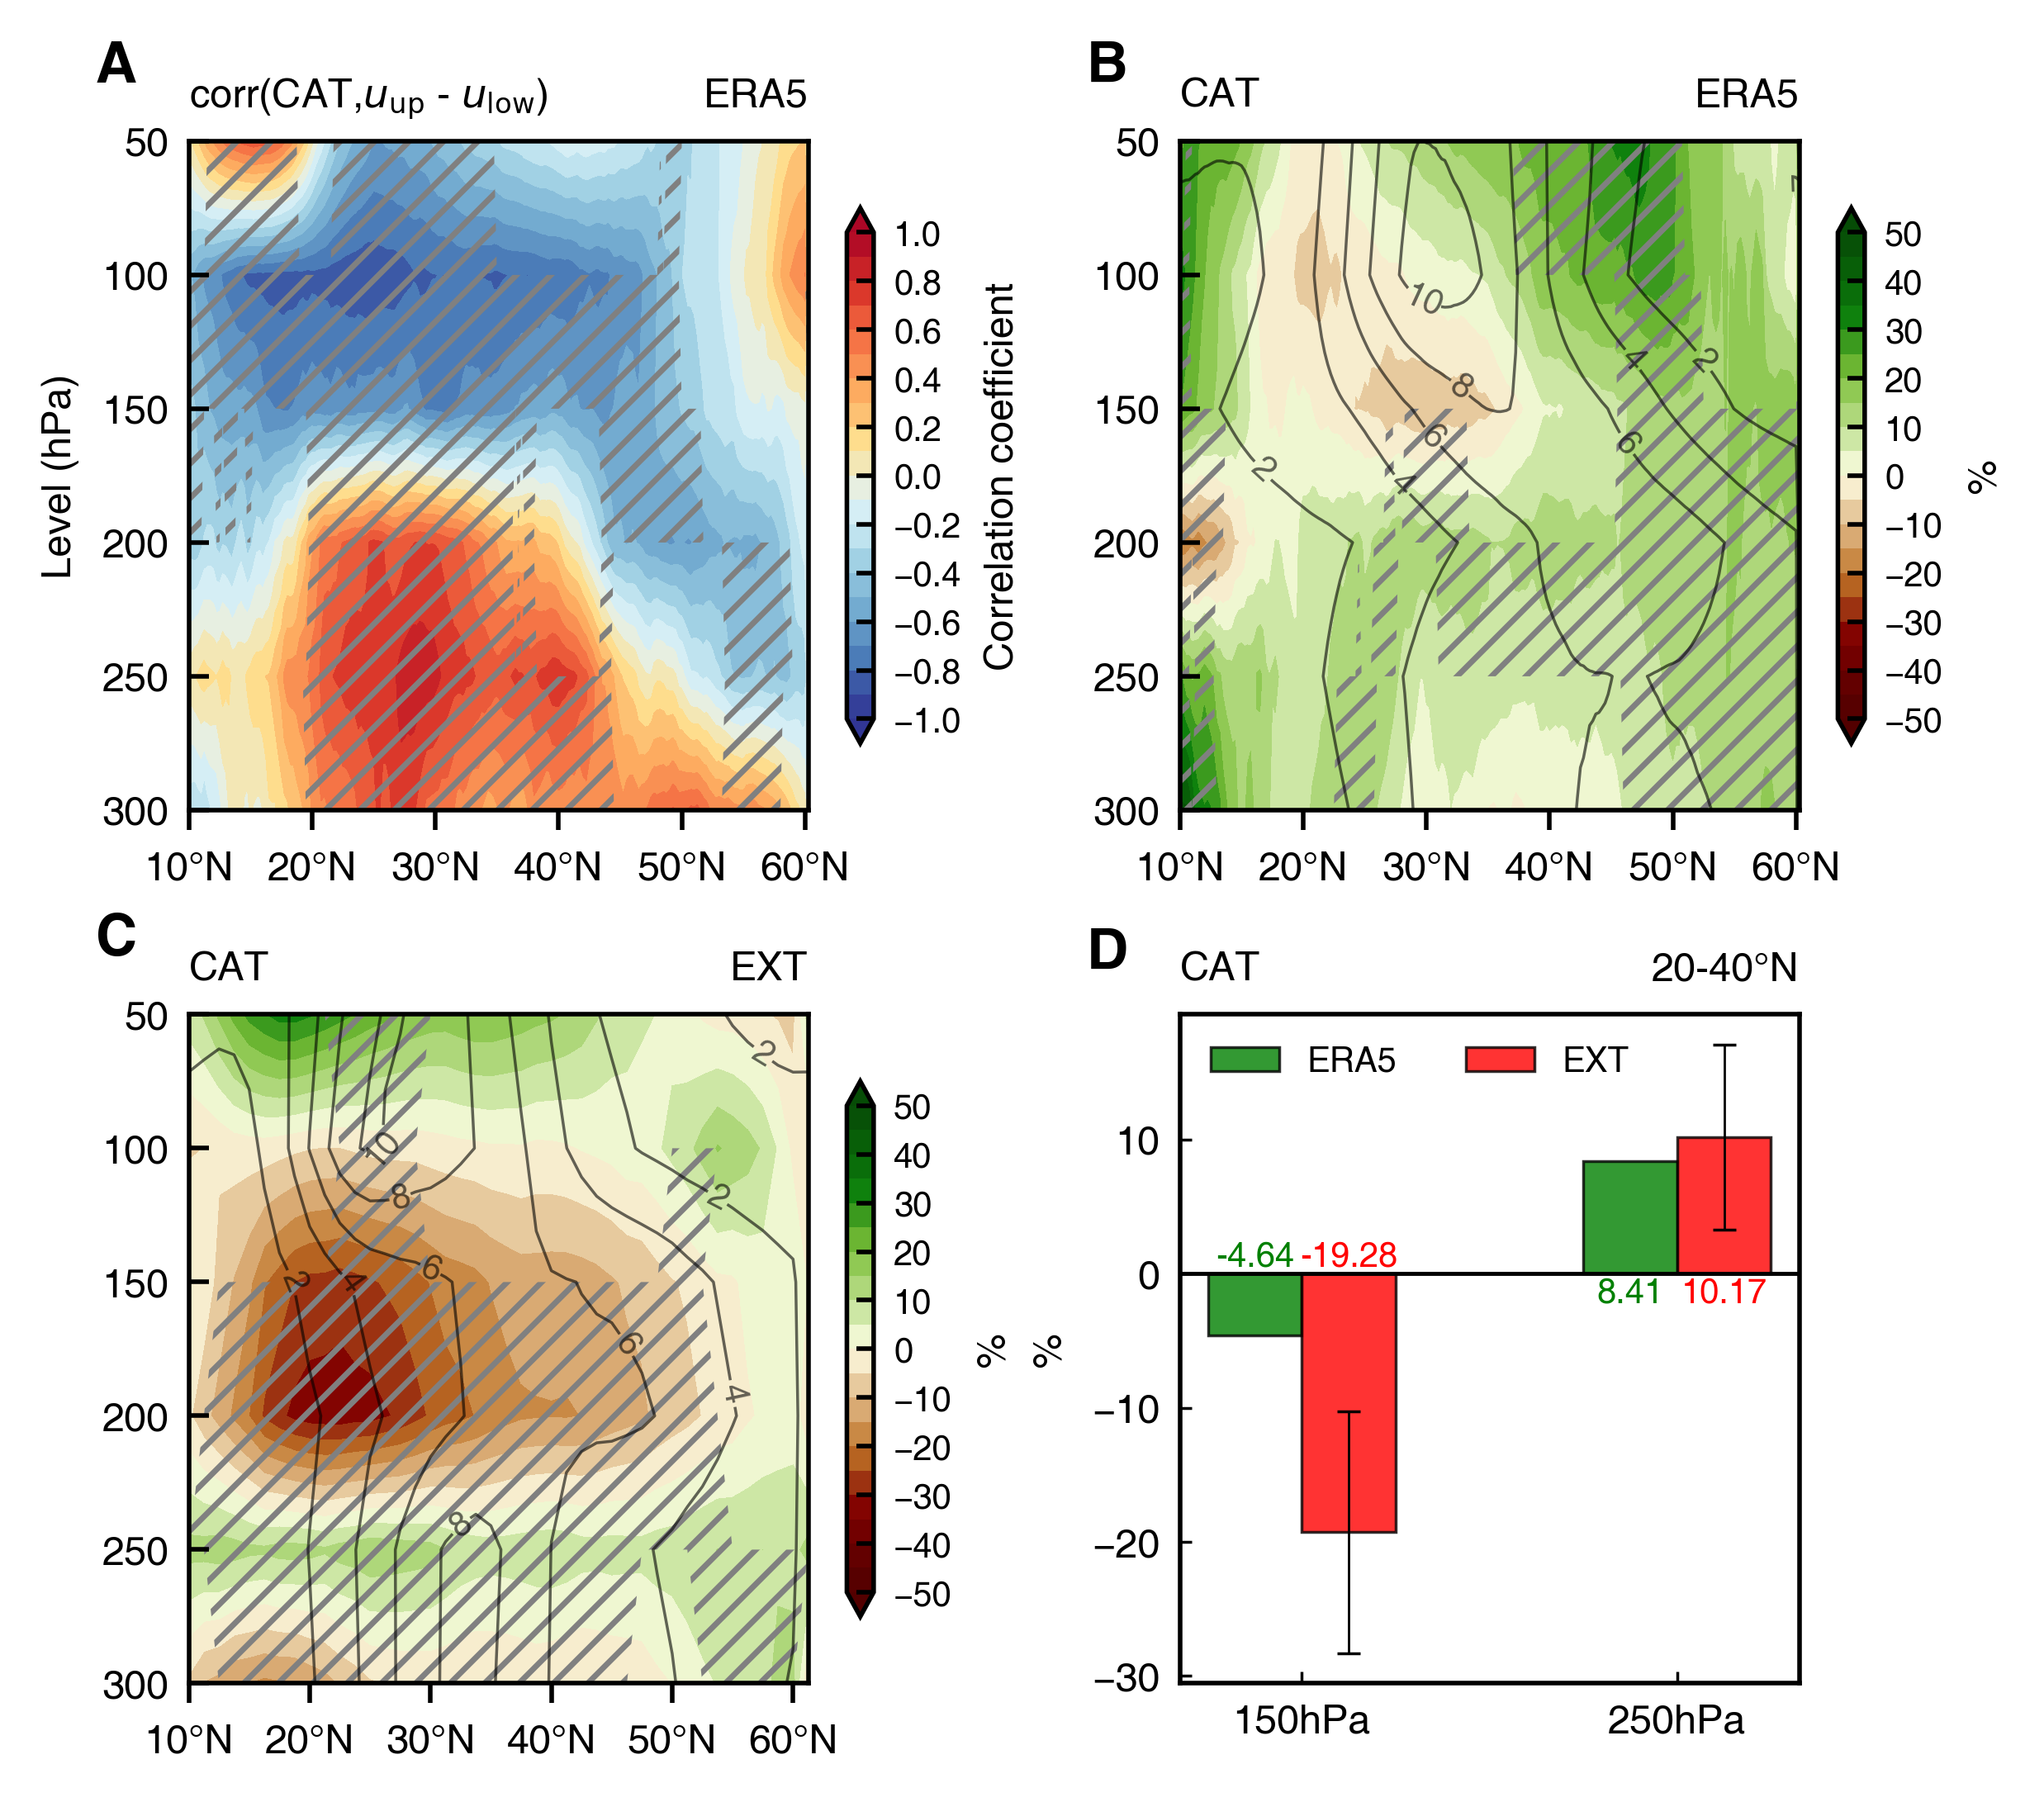

In [17]:
#level_label=['300','250','200','150','100','50']
IN_DIR = "/home/dongyl/Work2024/Tl/saved_npy/model_turbulence_data/h+ssp585_1980-2020/95p_frequency"
file = f'{IN_DIR}/TI1_h+ssp585_BCC-CSM2-MR_1980-2020_exceed_pct_{int(Q * 100)}p.nc'
TI_array= xr.open_dataset(file)
level = TI_array.plev[1:7]
print(TI_array.plev.shape)
level_label = list(map(int, (level.data/100).tolist()))
lat = TI_array.lat
lat_indices = np.where((lat >= 10) & (lat <= 60))[0]
lat = xr.open_dataset(f"{IN_DIR}/TI1_h+ssp585_BCC-CSM2-MR_1980-2020_exceed_pct_95p.nc").lat[lat_indices].values

file_era5 = xr.open_dataset(f"/home/dongyl/Work2_2025/ERA5_daily/era5_TI1_exceed_pct_{year}_{int(Q * 100)}p.nc")
lat_era5 = file_era5.lat
lat_indices_era5_10_60 = np.where((lat_era5 >= 10) & (lat_era5 <= 60))[0]
lat_era5 = xr.open_dataset(f"/home/dongyl/Work2_2025/ERA5_daily/era5_TI1_exceed_pct_{year}_{int(Q * 100)}p.nc").lat[lat_indices_era5_10_60].values
lat_indices_era5_10_80 = np.where((lat_era5 >= 10) & (lat_era5 <= 80))[0]
lat_era5_10_80 = combined_freq_new_zonmean.lat

fig = plt.figure(figsize=(5, 4.5), dpi=500)
axes = [[0.1,0.55,0.375,0.36], [0.58,0.55,0.375,0.36],
        [0.1,0.08,0.375,0.36],[0.58,0.08,0.3,0.36]]
'''def plot_meri_section(ax1, lat,level,level_label,
                      meri_data,meri_data_levels,ccmap,consistency,
                      left_title,colorbar_label,color_bar_ticks,sequence,
                      meri_clim=None,meri_clim_levels=None):'''

ax1 = plot_meri_section(ax1=fig.add_axes(axes[0]), lat=lat_era5,level=level,level_label=level_label, meri_data=r,
                  meri_data_levels=np.linspace(-1, 1, 21),ccmap=ccmap_u,consistency=consistency,
                        left_title=r'corr(CAT,$u_{\text{up}}$ - $u_{\text{low}}$)',right_title='ERA5',
                        colorbar_label='Correlation coefficient',
                        color_bar_ticks=np.arange(-1, 1.1, 0.2),sequence='A')
print(era5_TI_freq_trend.shape)
ax2 = plot_meri_section(ax1=fig.add_axes(axes[1]), lat=lat_era5,level=level,level_label=level_label,
meri_data=era5_TI_freq_trend/era5_TI_freq_clim*41*100,
                  meri_data_levels=np.linspace(-50, 50, 21),ccmap=ccmap_cat,consistency=era5_TI_significant_points,
                        left_title=r'CAT',right_title='ERA5',colorbar_label='%',
                        color_bar_ticks=np.linspace(-50, 50, 11),sequence='B',meri_clim=era5_TI_freq_clim,meri_clim_levels=np.arange(0, 13, 2))
ax3 = plot_meri_section(ax1=fig.add_axes(axes[2]), lat=lat,level=level,level_label=level_label,
                        meri_data=TI_freq_trend[1:7]/TI_freq_clim[1:]*41*100,
                  meri_data_levels=np.linspace(-50, 50, 21),ccmap=ccmap_cat,consistency=TI_significant_points[1:7],
                        left_title=r'CAT',right_title='EXT',colorbar_label='%',
                        color_bar_ticks=np.linspace(-50, 50, 11),sequence='C',meri_clim=TI_freq_clim[1:],meri_clim_levels=np.arange(0, 13, 2))

ax4 =  plot_bar(ax=fig.add_axes(axes[3]),ERA5_150=era5_TI_freq_aream_trend[3]/era5_TI_freq_aream_clim[3]*41*100,EXT_150=TI_all_models_aeram_trend_stack[:,4]/TI_all_models_aream_clim_stack[:,4]*41*100,
                ERA5_250=era5_TI_freq_aream_trend[1]/era5_TI_freq_aream_clim[1]*41*100,EXT_250=TI_all_models_aeram_trend_stack[:,2]/TI_all_models_aream_clim_stack[:,2]*41*100,right_title="20-40°N",
                left_title="CAT",sequence='D')
plt.savefig('/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/ScienceStyleFigures/Fig.3.TIcorrUupminuslow_relaTItrend_1980-2020_merisection_bar.png',format='png',dpi=300)
plt.savefig('/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/ScienceStyleFigures/Fig.3.TIcorrUupminuslow_relaTItrend_1980-2020_merisection_bar.svg',format='svg',dpi=300)
plt.show()